### Определение темы по постам группы вк

Будем собирать посты из группы "Лентач" во вконтакте с целью выявить тематику группы. Рассмотрим также на какие кластеры тем можно разбить посты.

Источник: https://webdevblog.ru/tematicheskoe-modelirovanie-s-pomoshhju-gensim-python/

Адаптировала под свои данные, под русскоязычный вариант

In [31]:
from time import time
import logging
import sys
import requests
import json
import datetime
from ast import literal_eval
import pandas as pd
import numpy as np
import configparser
import re
import nltk
from nltk.corpus import stopwords 
# from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
# lemma = WordNetLemmatizer()

import spacy
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package wordnet to /Users/mary/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Сбор информации. 



In [2]:
def gather_process():

    # gather data and save as txt
    id_ = 'lentach'
    owner_id = '29534144'# lentach
    count = 40
    offset = -1

    # In access_token.ini we have token for vk
    config = configparser.ConfigParser()
    config.read('access_token.ini')
    access_token = config.get('settings', 'token')
    
    for _ in range(100):
        url = 'https://api.vk.com/method/wall.get?owner_id=-{}&count={}&offset={}&v=5.52&access_token={}'.format(
            owner_id, count, offset + 1, access_token)
        respond = requests.get(url)
        with open(id_ + str(_) + '.txt', 'w') as outfile:
            json.dump(respond.json(), outfile)
        
        offset += count

In [3]:
def convert_data_to_table_format():
    
    # transform gathered data from txt file to pandas DataFrame and save as csv
    id_ = 'lentach'
    
    for _ in range(40):
        file = id_ + str(_) + '.txt'
        result = literal_eval(open(file, 'r').read())
        ids = []
        dates = []
        comments = []
        likes = []
        reposts = []
        text = []

        for item in result['response']['items']:
            ids.append(item['id'])
            dates.append(datetime.datetime.fromtimestamp(item['date']))
            comments.append(item['comments']['count'])
            likes.append(item['likes']['count'])
            reposts.append(item['reposts']['count'])
            text.append(item['text'].encode('utf-16', 'surrogatepass').decode('utf-16'))

        df = pd.DataFrame({
            "id": ids,
            "date": dates,
            "comments_count": comments,
            "likes_count": likes,
            "reposts_count": reposts,
            "text": text,
        })
        df.to_csv(id_ + str(_) + '.csv', sep='\t')
    
    pass



In [4]:
# Take latest 4 000 posts of lentach
# gather_process()

In [5]:
# Convert to csv
convert_data_to_table_format()

In [6]:
# Create 1 df from 40 files
df = pd.concat([pd.read_csv(r'lentach' + str(i) + '.csv', sep='\t') for i in range(40)], axis=0)
df.shape

(4000, 7)

In [7]:
df[98:103]

,Unnamed: 0,id,date,comments_count,likes_count,reposts_count,text
98,98,11435352,2019-07-02 12:35:12,133,2793,11,Чехия сняла ограничения на полёты российских а...
99,99,11434988,2019-07-02 11:35:06,198,8598,204,В декабре 2018 года студент ВГИКа Артём Фирсан...
0,0,11434891,2019-07-02 11:20:00,43,373,6,• «Интерфакс»: число жертв паводка в Иркутской...
1,1,11434549,2019-07-02 10:36:15,199,5763,78,"Цены на свинину, говядину и мясо птицы в Росси..."
2,2,11434254,2019-07-02 09:34:23,288,1718,15,Сегодня утром власти Чехии запретили «Аэрофлот...


In [8]:
df = df.set_index('id')
df = df.drop(['Unnamed: 0'], axis=1)

In [9]:
df.head()

,date,comments_count,likes_count,reposts_count,text
id,,,,,
11460130,2019-07-06 16:13:03,92,1146,15,Список «ремейки фильмов с женщинами в главной ...
11459911,2019-07-06 15:33:47,155,1803,31,В России планируется своя «Википедия».\n\nПрав...
11459474,2019-07-06 14:17:03,168,6437,231,"А вы тоже в детстве двигали мышкой по экрану, ..."
11459119,2019-07-06 13:23:59,130,4821,141,Уже десять лет каждую первую субботу июля росс...
11458585,2019-07-06 12:11:06,681,5606,81,Основатель Amazon Джефф Безос официально развё...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 11460130 to 10386610
Data columns (total 5 columns):
date              4000 non-null object
comments_count    4000 non-null int64
likes_count       4000 non-null int64
reposts_count     4000 non-null int64
text              3864 non-null object
dtypes: int64(3), object(2)
memory usage: 187.5+ KB


### 2. Обработка. 

* Удалим пропуски в значениях текста, т.к. никакая их обработка не поможет нашей цели
* Удалим русские стоп слова и знаки переноса строки (очистим текст)
* Разобьем каждый из текстов на отдельные слова
* Приведем слова к нормальной форме


In [11]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3864 entries, 11460130 to 10386610
Data columns (total 5 columns):
date              3864 non-null object
comments_count    3864 non-null int64
likes_count       3864 non-null int64
reposts_count     3864 non-null int64
text              3864 non-null object
dtypes: int64(3), object(2)
memory usage: 181.1+ KB


Первым делом (1) добавим в перечень стоп слов те, что не несут особой смысловой нагрузки

In [12]:
stop_words = stopwords.words('russian')
stop_words.extend(['http', 'https', 'lenta', 'ch', 'cc', 'ow', 'news', 'vk', 'upd', 'the', 'id', 'ows',
                   'который', 'это', 'один', 'главный', 'свой', 'такой', 'лентач', 'ещё', 'еще', 'самый', 'тот', 'пока', 
                   'мол', 'некоторый', 'почему', 'отдельный', 'год', 'неделя', 'сегодня', 'впервые', 'будущий', 'оно',
                  'сразу', 'затем', 'этот', 'также', 'жаль', 'сейчас', 'поэтому', 'лаифкаха', 'ввод', 'вывод', 'broco', 
                   'утро', 'последний', 'то', 'ничто', 'весь', 'стать', 'она', 'дать', 'хороший', 'весь', 'новый', 'имя', 
                   'oqib', 'день', 'хотеть', 'большой', 'наш', 'узнать', 'очень', 'сделаться', 'просто', 'час', 'минута',
                   'назад', 'сюда', 'увеличиться', 'отдельный', 'полностью', 'перестать', 'иметь', 'owyt', 'проходить', 
                   'июль', 'сделать', 'делать', 'читать', 'писать', 'число', 'считать', 'каждый', 'ряд', 'начало', 'конец', 
                   'пикчер', 'ваш', 'любой', 'снова', 'сколько', 'club', 'например', 'лишь', 'целый', 'начать', 
                   'получить', 'com', 'кстати', 'вместо', 'watch', 'один', 'два', 'три', 'четыре', 'пять', 'шесть', 'семь',
                    'восемь', 'девять', 'десять','третье', 'мем', 'мема', 'слово', 'пара', 'январь', 'сегодня', 'суббота', 
                   'ждать', 'ru', 'часто', 'тема', 'название', 'вокруг', 'oiahd', 'никто',  'остаться', 'сотня', 'сказать', 
                   'называть', 'предложение', 'представить', 'собираться', 'предложение', 'около', 'нужно', 'сильно', 'вокруг',
                   'именно', 'отправить', 'получать', 'бывший', 'вчера', 'май', 'апрель', 'несколько', 'продолжать', 'март', 
                   'взять', 'пройтись', 'использовать', 'почитать', 'вообще', 'рассказать', 'оказаться', 'rowp', 'ro', 'rrzf', 
                   'никак', 'хотя', 'rreq', 'grace', 'three','ropr', 'практически', 'rrg', 'rofm',
                   'вдвое', 'полтора', 'говориться', 'месяц', 'вечером', 'известный', 'начинать', 'основать', 'слишком',
                   'подвести', 'идти', 'принести', 'distemper', 'внезапно', 'наиболее', 'известный', 'качество', 'являться',
                   'обнаружить', 'in', 'напомнить', 'образовать', 'интересный', 'составить', 'насколько', 'появиться', 'давать',
                   'новое', 'новость', 'найти', 'давно', 'готовый', 'продолжаться', 'раз',
                   'ответ', 'применение', 'кажется', 'готовый', 'новость', 'говорить', 'выглядеть', 'нибыть', 'попытаться',
                   'первое', 'уровень', 'искать', 'сторона', 'удаться', 'выяснить', 'против', 'назвать', 'мочь',
                   'возможность', 'настоящий', 'человек', 'время', 'летний', 'вид', 'прошлое', 'ранее',
                   'цель', 'теория', 'смочь', 'однако', 'количество', 'создать', 'многие', 'пытаться', 'минимум', 
                   'вместе', 'тысяча', 'высокий', 'менее', 'цель', 'подробность', 'момент', 'ровно', 'часть', 'недавно', 
                   'знак', 'благодаря', 'важный', 'снег', 'написать', 
                   'твой', 'вариант', 'изменить', 'очередь', 'актуальный', 'зимний', 'второе', 'set up', 'включая',
                   'олд', 'оба', 'итог', 'век', 'среди', 'говорят', 'простой', 'таки', 'вопрос', 'никакой', 'немного',
                   'спасибо', 'единственный', 'добавить', 'вовсе', 'попасть', 'строить', 'крутой', 'идея', 'вырасти', 
                   'рост', 'ребята', 'часы', 'ночь', 'правило', 'вид'
                  ])
stop_words = set(stop_words)

In [23]:
# Convert to list
data = df.text.values.tolist()

def cleaning(input_data):
    data = input_data
    # Remove Emails
    data = [re.sub('\S*http\S*\s?', '', sent) for sent in data]
    data = [re.sub('\S*https\S*\s?', '', sent) for sent in data]
    data = [re.sub(r'\n', ' ', sent, flags=re.IGNORECASE) for sent in data]
    data = [re.sub(r'•', '', sent, flags=re.IGNORECASE) for sent in data]
    data = [sent.replace('ё','е') for sent in data]
    data = [re.sub('\s+', ' ', sent) for sent in data]
    data = [re.sub("\'", "", sent) for sent in data]
    return data
    
pprint(data[:1]) 

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])

['Список «ремейки фильмов с женщинами в главной роли» может пополниться еще '
 'одной картиной. На этот раз в лучших традициях последних лет планируют '
 'переснять ту самую «Маску» с Джимом Кэрри ']
[['список', 'ремеики', 'фильмов', 'женщинами', 'главнои', 'роли', 'может', 'пополниться', 'еще', 'однои', 'картинои', 'на', 'этот', 'раз', 'лучших', 'традициях', 'последних', 'лет', 'планируют', 'переснять', 'ту', 'самую', 'маску', 'джимом', 'кэрри']]


In [26]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['список', 'ремеики', 'фильмов', 'женщинами', 'главнои', 'роли', 'может', 'пополниться', 'еще', 'однои', 'картинои', 'на', 'этот_раз', 'лучших', 'традициях', 'последних', 'лет', 'планируют', 'переснять', 'ту', 'самую', 'маску', 'джимом', 'кэрри']


In [139]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) \
             if morph.parse(word)[0].normal_form not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def doc_to_words(texts, stop_words, morph):
#     words = [morph.parse(w)[0].normal_form for w in str(doc) \
#              if morph.parse(w)[0].normal_form not in stop_words]    
#     return words
    texts_out=[]
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([morph.parse(token)[0].normal_form for token in simple_preprocess(str(doc)) \
                          if morph.parse(token)[0].normal_form not in stop_words])
    return texts_out

In [140]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [142]:
# Do lemmatization 
morph = pymorphy2.MorphAnalyzer()
data_lemmatized = doc_to_words(data_words_bigrams, stop_words, morph)

In [144]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


In [148]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[2:3]]

[[('win', 1),
  ('windows', 1),
  ('буфер', 2),
  ('быстрый', 1),
  ('выполнять', 2),
  ('выполняться', 1),
  ('выясниться', 1),
  ('двигать', 2),
  ('движение', 2),
  ('детство', 1),
  ('дефрагментация', 1),
  ('диск', 1),
  ('дожидаться', 1),
  ('загружаться', 1),
  ('загрузка', 2),
  ('задача', 5),
  ('задержка', 1),
  ('запуск', 1),
  ('значительно', 1),
  ('клавиатура', 1),
  ('комп', 1),
  ('крупный', 1),
  ('лайфкаха', 1),
  ('многозадачность', 1),
  ('моментально', 1),
  ('мышка', 4),
  ('набраться', 1),
  ('наполняться', 1),
  ('нужный', 1),
  ('печать', 1),
  ('повторяться', 1),
  ('получаться', 1),
  ('пользователь', 1),
  ('правый', 1),
  ('приоритетный', 1),
  ('программа', 1),
  ('работать', 3),
  ('система', 2),
  ('скорость', 1),
  ('совершать', 1),
  ('сожаление', 1),
  ('сокращаться', 1),
  ('счёт', 1),
  ('ускорить', 1),
  ('ускоряться', 1),
  ('устанавливаться', 1),
  ('установка', 3),
  ('фич', 1),
  ('фоновый', 2),
  ('цикл', 1),
  ('циклично', 1),
  ('экран', 1)]

### 3. Построение моделей

Попробуем разбить тексты на несколько тематик: построим зависимость когерентности от количества тематик; оптимальное число отобразим


In [155]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Time to count coherence values: 24.3 mins


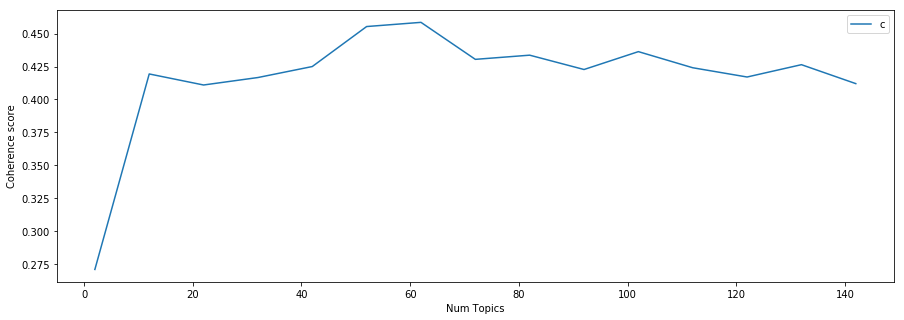

2:  0.2707088210535149
12:  0.4193895662399309
22:  0.41099547362870026
32:  0.41667339281778126
42:  0.4250340119351782
52:  0.45545123370942286
62:  0.458638321941553
72:  0.4305015291776251
82:  0.4336775331534823
92:  0.4227771084344116
102:  0.4363693144254505
112:  0.424114893269025
122:  0.41707065628531415
132:  0.42644840526262423
142:  0.4120423811526244


In [160]:
limit=150; start=2; step=10;
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

Time to count coherence values: 12.25 mins


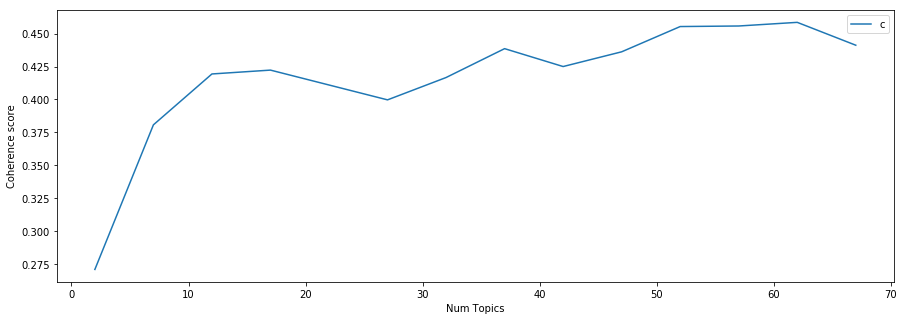

2:  0.2707088210535149
7:  0.38068321506414365
12:  0.4193895662399309
17:  0.4223178089126898
22:  0.41099547362870026
27:  0.399688479238142
32:  0.41667339281778126
37:  0.4386383039871964
42:  0.4250340119351782
47:  0.4362346272172629
52:  0.45545123370942286
57:  0.4558701664001293
62:  0.458638321941553
67:  0.44124729799085566


In [161]:
limit=70; start=2; step=5;
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

Time to count coherence values: 11.37 mins


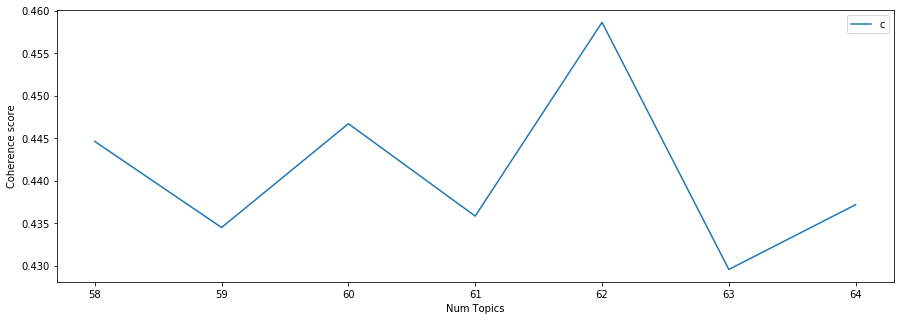

58:  0.44462090858602116
59:  0.43447852372481666
60:  0.4467040883031584
61:  0.4358245562132973
62:  0.458638321941553
63:  0.4295416968273387
64:  0.4371711074918609


In [163]:
limit=65; start=58; step=1;
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

Судя по построенным графикам, наиболее оптимальное число тем = 62

In [164]:
t=time()
lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=62, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True);

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print('\nTime to build model & count scores: {} mins'.format(round((time() - t) / 60, 2)))
print()
pprint(lda_model.print_topics(-1))


Perplexity:  -49.59351058049345

Coherence Score:  nan

Time to build model & count scores: 1.49 mins

[(0,
  '0.139*"полицейский" + 0.125*"протест" + 0.088*"причина" + 0.060*"начаться" '
  '+ 0.055*"китайский" + 0.033*"парень" + 0.032*"рынок" + 0.024*"телефон" + '
  '0.009*"huawei" + 0.007*"июнь"'),
 (1,
  '0.000*"курский" + 0.000*"квитанция" + 0.000*"возникать" + 0.000*"аллергия" '
  '+ 0.000*"rrvt" + 0.000*"полмиллиона" + 0.000*"rryv" + 0.000*"непривитый" + '
  '0.000*"жилища" + 0.000*"rrci"'),
 (2,
  '0.289*"москва" + 0.180*"задержать" + 0.040*"управление" + 0.035*"звание" + '
  '0.035*"жертва" + 0.028*"герой" + 0.028*"хищение" + 0.027*"подозрение" + '
  '0.023*"общественный" + 0.016*"владимир_путин"'),
 (3,
  '0.195*"суд" + 0.102*"чёрный" + 0.065*"должный" + 0.053*"крупный" + '
  '0.041*"расследование" + 0.031*"фсб" + 0.031*"смотреть" + 0.021*"насилие" + '
  '0.017*"полковник" + 0.017*"америка"'),
 (4,
  '0.072*"руководство" + 0.068*"направить" + 0.041*"кампания" + '
  '0.033*"по

Группы распознаются весьма неплохо, но можно почистить слова еще:

In [165]:
stop_words = stopwords.words('russian')
stop_words.extend(['http', 'https', 'lenta', 'ch', 'cc', 'ow', 'news', 'vk', 'upd', 'the', 'id', 'ows',
                   'который', 'это', 'один', 'главный', 'свой', 'такой', 'лентач', 'ещё', 'еще', 'самый', 'тот', 'пока', 
                   'мол', 'некоторый', 'почему', 'отдельный', 'год', 'неделя', 'сегодня', 'впервые', 'будущий', 'оно',
                  'сразу', 'затем', 'этот', 'также', 'жаль', 'сейчас', 'поэтому', 'лаифкаха', 'ввод', 'вывод', 'broco', 
                   'утро', 'последний', 'то', 'ничто', 'весь', 'стать', 'она', 'дать', 'хороший', 'весь', 'новый', 'имя', 
                   'oqib', 'день', 'хотеть', 'большой', 'наш', 'узнать', 'очень', 'сделаться', 'просто', 'час', 'минута',
                   'назад', 'сюда', 'увеличиться', 'отдельный', 'полностью', 'перестать', 'иметь', 'owyt', 'проходить', 
                   'июль', 'сделать', 'делать', 'читать', 'писать', 'число', 'считать', 'каждый', 'ряд', 'начало', 'конец', 
                   'пикчер', 'ваш', 'любой', 'снова', 'сколько', 'club', 'например', 'лишь', 'целый', 'начать', 
                   'получить', 'com', 'кстати', 'вместо', 'watch', 'один', 'два', 'три', 'четыре', 'пять', 'шесть', 'семь',
                    'восемь', 'девять', 'десять','третье', 'мем', 'мема', 'слово', 'пара', 'январь', 'сегодня', 'суббота', 
                   'ждать', 'ru', 'часто', 'тема', 'название', 'вокруг', 'oiahd', 'никто',  'остаться', 'сотня', 'сказать', 
                   'называть', 'предложение', 'представить', 'собираться', 'предложение', 'около', 'нужно', 'сильно', 'вокруг',
                   'именно', 'отправить', 'получать', 'бывший', 'вчера', 'май', 'апрель', 'несколько', 'продолжать', 'март', 
                   'взять', 'пройтись', 'использовать', 'почитать', 'вообще', 'рассказать', 'оказаться', 'rowp', 'ro', 'rrzf', 
                   'никак', 'хотя', 'rreq', 'grace', 'three','ropr', 'практически', 'rrg', 'rofm',
                   'вдвое', 'полтора', 'говориться', 'месяц', 'вечером', 'известный', 'начинать', 'основать', 'слишком',
                   'подвести', 'идти', 'принести', 'distemper', 'внезапно', 'наиболее', 'известный', 'качество', 'являться',
                   'обнаружить', 'in', 'напомнить', 'образовать', 'интересный', 'составить', 'насколько', 'появиться', 'давать',
                   'новое', 'новость', 'найти', 'давно', 'готовый', 'продолжаться', 'раз',
                   'ответ', 'применение', 'кажется', 'готовый', 'новость', 'говорить', 'выглядеть', 'нибыть', 'попытаться',
                   'первое', 'уровень', 'искать', 'сторона', 'удаться', 'выяснить', 'против', 'назвать', 'мочь',
                   'возможность', 'настоящий', 'человек', 'время', 'летний', 'вид', 'прошлое', 'ранее',
                   'цель', 'теория', 'смочь', 'однако', 'количество', 'создать', 'многие', 'пытаться', 'минимум', 
                   'вместе', 'тысяча', 'высокий', 'менее', 'цель', 'подробность', 'момент', 'ровно', 'часть', 'недавно', 
                   'знак', 'благодаря', 'важный', 'снег', 'написать', 
                   'твой', 'вариант', 'изменить', 'очередь', 'актуальный', 'зимний', 'второе', 'set up', 'включая',
                   'олд', 'оба', 'итог', 'век', 'среди', 'говорят', 'простой', 'таки', 'вопрос', 'никакой', 'немного',
                   'спасибо', 'единственный', 'добавить', 'вовсе', 'попасть', 'строить', 'крутой', 'идея', 'вырасти', 
                   'рост', 'ребята', 'часы', 'ночь', 'правило', 'вид','rryv','rrci','rrvt','целое','сутки',
                   'несмотря','нужный','изначально','поздний','показать', 'возникать','вход','видеть','откуда',
                   'ii','al','ou','rrml','разный','ночью', 'полгода'
                  ])
stop_words = set(stop_words)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization 
morph = pymorphy2.MorphAnalyzer()
data_lemmatized = doc_to_words(data_words_bigrams, stop_words, morph)

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

Time to count coherence values: 10.98 mins


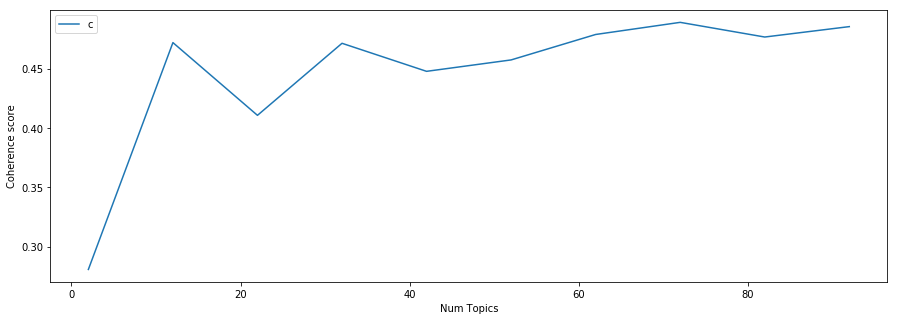

2:  0.28092476735207794
12:  0.4718534673255312
22:  0.41063782184725073
32:  0.47127799624214534
42:  0.4476739060991997
52:  0.45727238590253666
62:  0.47869181982262515
72:  0.48889775033907096
82:  0.47655103173213115
92:  0.48530765539489507


In [166]:
limit=100; start=2; step=10;
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

Time to count coherence values: 5.64 mins


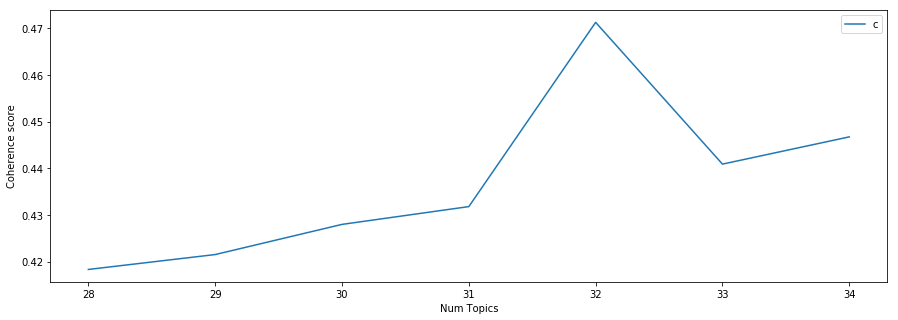

28:  0.41835249102094674
29:  0.42154191275091546
30:  0.4280024559201977
31:  0.43181545722847375
32:  0.47127799624214534
33:  0.4409134031367488
34:  0.44674802463373153


In [167]:
start=28; step=1;limit=35; 
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

Time to count coherence values: 3.92 mins


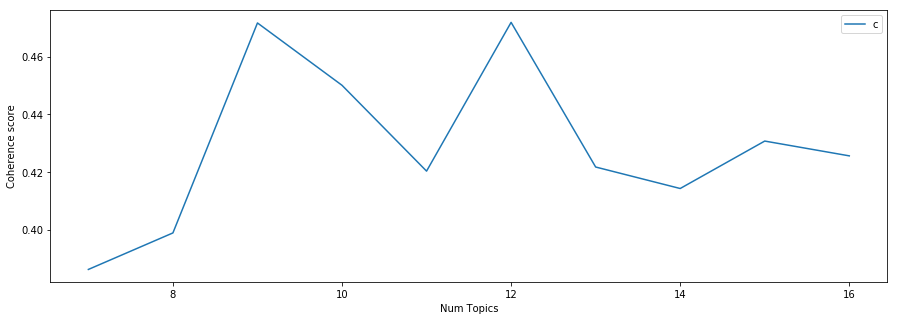

7:  0.3861460336109031
8:  0.39881579209405615
9:  0.4716451560968036
10:  0.45002099214398816
11:  0.4202525446660012
12:  0.4718534673255312
13:  0.42167738044894243
14:  0.41422017496860847
15:  0.43067725490868436
16:  0.4255446827156189


In [168]:
start=7; step=1;limit=17; 
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

In [169]:
t=time()
lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=12, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True);

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print('\nTime to build model & count scores: {} mins'.format(round((time() - t) / 60, 2)))
print()
pprint(lda_model.print_topics(-1))


Perplexity:  -12.420698981390071

Coherence Score:  0.47609967857883445

Time to build model & count scores: 0.44 mins

[(0,
  '0.051*"сша" + 0.036*"радиолентач" + 0.032*"дом" + 0.028*"американский" + '
  '0.027*"традиционный" + 0.027*"группа" + 0.021*"мадурый" + 0.015*"лидер" + '
  '0.014*"альбом" + 0.013*"миллион"'),
 (1,
  '0.044*"россиянин" + 0.040*"венесуэла" + 0.031*"женщина" + 0.019*"пассажир" '
  '+ 0.014*"чечня" + 0.014*"русский" + 0.013*"угроза" + 0.013*"разрешить" + '
  '0.011*"обвинить" + 0.010*"личный"'),
 (2,
  '0.076*"страна" + 0.027*"чёрный" + 0.021*"планировать" + 0.020*"студент" + '
  '0.018*"население" + 0.016*"предлагать" + 0.015*"британский" + '
  '0.014*"канада" + 0.014*"девочка" + 0.013*"половина"'),
 (3,
  '0.027*"город" + 0.026*"сми" + 0.020*"житель" + 0.017*"область" + '
  '0.017*"история" + 0.016*"пройти" + 0.016*"место" + 0.014*"сообщить" + '
  '0.014*"сообщать" + 0.012*"москва"'),
 (4,
  '0.037*"интернет" + 0.034*"мир" + 0.032*"февраль" + 0.030*"объявить" 

In [170]:
t=time()
lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=9, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True);

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print('\nTime to build model & count scores: {} mins'.format(round((time() - t) / 60, 2)))
print()
pprint(lda_model.print_topics(-1))


Perplexity:  -10.385172773344099

Coherence Score:  0.4719485391554946

Time to build model & count scores: 0.36 mins

[(0,
  '0.031*"сша" + 0.022*"радиолентач" + 0.021*"история" + 0.019*"венесуэла" + '
  '0.017*"американский" + 0.017*"традиционный" + 0.016*"группа" + '
  '0.012*"сообщение" + 0.010*"правительство" + 0.009*"лидер"'),
 (1,
  '0.037*"школа" + 0.028*"фильм" + 0.020*"женщина" + 0.020*"глава" + '
  '0.013*"находиться" + 0.012*"снять" + 0.011*"борт" + 0.010*"фотография" + '
  '0.009*"оскар" + 0.009*"семья"'),
 (2,
  '0.016*"компания" + 0.014*"мир" + 0.014*"госдума" + 0.012*"законопроект" + '
  '0.012*"закон" + 0.012*"принять" + 0.010*"отказаться" + 0.010*"чёрный" + '
  '0.007*"студент" + 0.007*"война"'),
 (3,
  '0.033*"россия" + 0.018*"город" + 0.018*"сми" + 0.016*"рубль" + '
  '0.013*"житель" + 0.012*"область" + 0.011*"место" + 0.010*"пройти" + '
  '0.009*"сообщить" + 0.009*"сообщать"'),
 (4,
  '0.020*"регион" + 0.017*"участие" + 0.012*"ск" + 0.012*"население" + '
  '0.011*

In [171]:
t=time()
lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=32, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True);

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print('\nTime to build model & count scores: {} mins'.format(round((time() - t) / 60, 2)))
print()
pprint(lda_model.print_topics(-1))


Perplexity:  -29.66146929341165

Coherence Score:  nan

Time to build model & count scores: 0.8 mins

[(0,
  '0.118*"радиолентач" + 0.092*"американский" + 0.090*"традиционный" + '
  '0.088*"группа" + 0.045*"альбом" + 0.044*"миллион" + 0.041*"рок_группа" + '
  '0.035*"выпустить" + 0.021*"уйти" + 0.020*"существование"'),
 (1,
  '0.069*"соцсеть" + 0.060*"торговый" + 0.048*"устроить" + 0.030*"стрельба" + '
  '0.029*"рунет" + 0.018*"автомобиль" + 0.016*"тонна" + 0.015*"учебный" + '
  '0.014*"река" + 0.012*"очевидец"'),
 (2,
  '0.351*"россия" + 0.041*"поддержать" + 0.035*"предлагать" + '
  '0.021*"журналист" + 0.020*"направить" + 0.018*"уходить" + 0.018*"интервью" '
  '+ 0.015*"обязательный" + 0.015*"единый" + 0.012*"телеканал"'),
 (3,
  '0.080*"здание" + 0.080*"результат" + 0.078*"погибнуть" + 0.046*"ск" + '
  '0.041*"помочь" + 0.036*"проверка" + 0.025*"экипаж" + 0.025*"новосибирск" + '
  '0.023*"движение" + 0.023*"мэрия"'),
 (4,
  '0.000*"профилактика" + 0.000*"аллергия" + 0.000*"отборный

Остановимся на следующем варианте дополнително выделенных стоп слов:

In [187]:
t=time()
stop_words = stopwords.words('russian')
stop_words.extend(['http', 'https', 'lenta', 'ch', 'cc', 'ow', 'news', 'vk', 'upd', 'the', 'id', 'ows',
                   'который', 'это', 'один', 'главный', 'свой', 'такой', 'лентач', 'ещё', 'еще', 'самый', 'тот', 'пока', 
                   'мол', 'некоторый', 'почему', 'отдельный', 'год', 'неделя', 'сегодня', 'будущий', 'оно',
                  'сразу', 'затем', 'этот', 'также', 'жаль', 'сейчас', 'поэтому', 'лаифкаха', 'ввод', 'вывод', 'broco', 
                   'утро', 'последний', 'то', 'ничто', 'весь', 'стать', 'она', 'дать', 'хороший', 'весь', 'новый', 'имя', 
                   'oqib', 'день', 'хотеть', 'большой', 'наш', 'узнать', 'очень', 'сделаться', 'просто', 'час', 'минута',
                   'назад', 'сюда', 'увеличиться', 'отдельный', 'полностью', 'перестать', 'иметь', 'owyt', 
                   'июль', 'сделать', 'делать', 'читать', 'писать', 'число', 'считать', 'каждый', 'ряд', 'начало', 'конец', 
                   'пикчер', 'ваш', 'любой', 'снова', 'сколько', 'club', 'например', 'лишь', 'целый', 'начать', 
                   'получить', 'com', 'кстати', 'вместо', 'watch', 'один', 'два', 'три', 'четыре', 'пять', 'шесть', 'семь',
                    'восемь', 'девять', 'десять','третье', 'мем', 'мема', 'слово', 'пара', 'январь', 'сегодня', 'суббота', 
                   'ждать', 'ru', 'часто', 'тема', 'название', 'вокруг', 'oiahd', 'никто',  'остаться', 'сотня', 'сказать', 
                   'называть', 'предложение', 'представить', 'собираться', 'около', 'нужно', 'сильно', 'вокруг',
                   'именно', 'отправить', 'получать', 'бывший', 'вчера', 'май', 'апрель', 'несколько', 'продолжать', 'март', 
                   'взять', 'пройтись', 'использовать', 'почитать', 'вообще', 'рассказать', 'оказаться', 'rowp', 'ro', 'rrzf', 
                   'никак', 'хотя', 'rreq', 'grace', 'three','ropr', 'практически', 'rrg', 'rofm',
                   'вдвое', 'полтора', 'говориться', 'месяц', 'вечером', 'известный', 'начинать', 'основать', 'слишком',
                   'подвести', 'идти', 'принести', 'distemper', 'внезапно', 'наиболее', 'качество', 'являться',
                   'in', 'напомнить', 'образовать', 'интересный', 'составить', 'насколько', 'появиться', 'давать',
                   'новое', 'новость', 'найти', 'давно', 'готовый', 'продолжаться', 'раз',
                   'ответ', 'применение', 'кажется', 'готовый', 'новость', 'говорить', 'выглядеть', 'нибыть', 'попытаться',
                   'первое', 'уровень', 'сторона', 'удаться', 'выяснить', 'назвать', 'мочь',
                   'возможность', 'настоящий', 'человек', 'время', 'летний', 'вид', 'прошлое', 'ранее',
                   'цель', 'теория', 'смочь', 'однако', 'количество', 'создать', 'многие', 'пытаться', 'минимум', 
                   'вместе', 'тысяча', 'высокий', 'менее', 'цель', 'подробность', 'момент', 'ровно', 'часть', 'недавно', 
                   'знак', 'благодаря', 'важный', 'снег', 'написать', 
                   'твой', 'вариант', 'изменить', 'очередь', 'актуальный', 'зимний', 'второе', 'set up', 'включая',
                   'олд', 'оба', 'итог', 'век', 'среди', 'говорят', 'простой', 'таки', 'вопрос', 'никакой', 'немного',
                   'спасибо', 'единственный', 'добавить', 'вовсе', 'попасть', 'строить', 'крутой', 'идея', 'вырасти', 
                   'рост', 'ребята', 'часы', 'ночь', 'правило', 'вид','rryv','rrci','rrvt','целое','сутки',
                   'несмотря','нужный','изначально','поздний','показать', 'возникать','вход','видеть','откуда',
                   'ii','al','ou','rrml','разный','ночью', 'ton', 'фото', 'девушка', 'должный', 'слышать', 
                   'смотреть', 'стол', 'ssj', 'основной', 'полмиллиона', 'скажем', 'половина', 'радовать', 'рука', 
                   'полгода', 'иначе', 'ef', 'многий', 'возможно', 'миллион', 'прийтись', 'секунда'
                  ])
stop_words = set(stop_words)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization 
morph = pymorphy2.MorphAnalyzer()
data_lemmatized = doc_to_words(data_words_bigrams, stop_words, morph)

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))


Time to count coherence values: 1.15 mins


Time to count coherence values: 15.31 mins


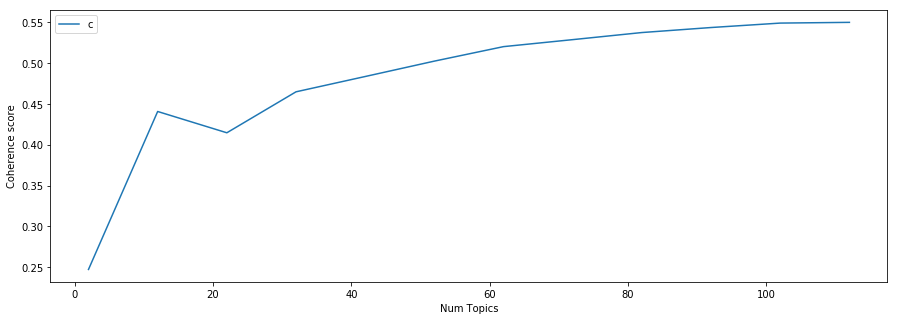

2:  0.2473509051805935
12:  0.44075806344988244
22:  0.4146957507431153
32:  0.4648560331074475
42:  0.48359352532056865
52:  0.5024337334474596
62:  0.5201770012827277
72:  0.5287377651801699
82:  0.5374231045619791
92:  0.5435680998897074
102:  0.5490030692598803
112:  0.5499012146118701


In [188]:
start=2; step=10;limit=120; 
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

Судя по графику имеет смысл рассмотреть 2 участка: в районе 12 и 32. Далее количество тем начинает расти значительно, принося очень небольшой выигрыш в зачении когерентности.

Time to count coherence values: 4.12 mins


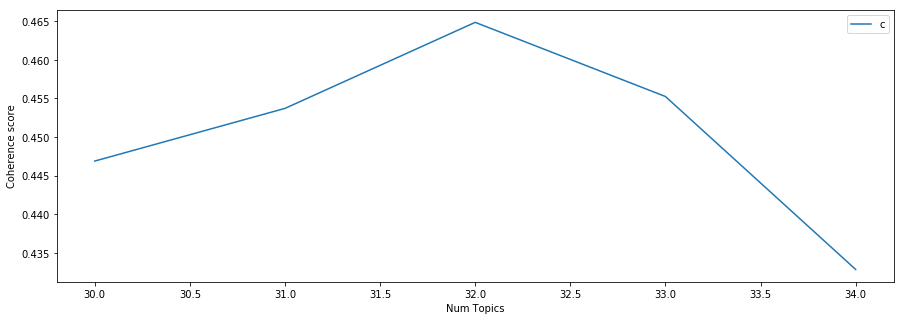

30:  0.44689793008477363
31:  0.45371645398046145
32:  0.4648560331074475
33:  0.45525726483350326
34:  0.4328658637437486


In [190]:
# 30-35
start=30; step=1;limit=35; 
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

In [192]:
t=time()
lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=32, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True);

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print('\nTime to build model & count scores: {} mins'.format(round((time() - t) / 60, 2)))
print()
pprint(lda_model.print_topics(-1))


Perplexity:  -29.819186721530134

Coherence Score:  0.4703724950925552

Time to build model & count scores: 0.91 mins

[(0,
  '0.118*"путин" + 0.117*"работа" + 0.064*"чёрный" + 0.055*"собрать" + '
  '0.037*"политика" + 0.036*"трамп" + 0.035*"британский" + 0.031*"комментарий" '
  '+ 0.024*"художник" + 0.022*"уйти"'),
 (1,
  '0.000*"махинация" + 0.000*"санитар" + 0.000*"платформа" + 0.000*"блокчейн" '
  '+ 0.000*"отборный" + 0.000*"кинолента" + 0.000*"главбух" + '
  '0.000*"квитанция" + 0.000*"аллергия" + 0.000*"выдворить"'),
 (2,
  '0.105*"суд" + 0.093*"дом" + 0.054*"больница" + 0.042*"признать" + '
  '0.042*"запретить" + 0.033*"долг" + 0.024*"решение" + 0.024*"подозревать" + '
  '0.023*"республика" + 0.023*"детский"'),
 (3,
  '0.105*"здание" + 0.085*"участие" + 0.054*"помочь" + 0.049*"семья" + '
  '0.033*"новосибирск" + 0.030*"мэрия" + 0.024*"жительница" + 0.016*"волонтёр" '
  '+ 0.013*"нож" + 0.012*"участвовать"'),
 (4,
  '0.058*"смерть" + 0.050*"минобороны" + 0.020*"кокорин" + 0.017

Time to count coherence values: 2.38 mins


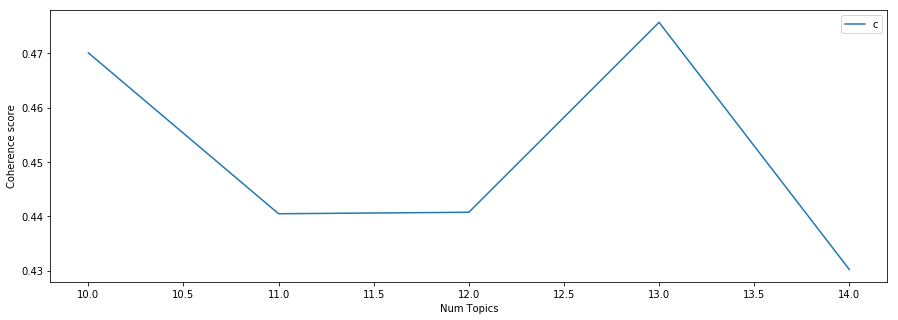

10:  0.4700726183121028
11:  0.440485361129878
12:  0.44075806344988244
13:  0.4756825202625787
14:  0.4302421858282458


In [189]:
# 10-15
start=10; step=1;limit=15; 
t=time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

print('Time to count coherence values: {} mins'.format(round((time() - t) / 60, 2)))

x = range(start, limit, step)
plt.figure(figsize=(15,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for i, j in enumerate(coherence_values):
    print(str(start + i*step) + ':  ' + str(j))

In [191]:
t=time()
lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=13, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True);

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print('\nTime to build model & count scores: {} mins'.format(round((time() - t) / 60, 2)))
print()
pprint(lda_model.print_topics(-1))


Perplexity:  -13.76294018585757

Coherence Score:  0.4793015826576377

Time to build model & count scores: 0.48 mins

[(0,
  '0.094*"страна" + 0.061*"история" + 0.029*"находиться" + 0.025*"студент" + '
  '0.022*"чиновник" + 0.018*"канада" + 0.016*"опасный" + 0.015*"собака" + '
  '0.014*"розыгрыш" + 0.012*"минобороны"'),
 (1,
  '0.051*"самолёт" + 0.028*"снять" + 0.026*"борт" + 0.022*"арестовать" + '
  '0.021*"вконтакте" + 0.017*"захватить" + 0.014*"евро" + 0.013*"аэропорт" + '
  '0.013*"фейковы" + 0.013*"министр"'),
 (2,
  '0.038*"ребёнок" + 0.037*"суд" + 0.027*"петербург" + 0.023*"погибнуть" + '
  '0.022*"регион" + 0.021*"решить" + 0.020*"взрыв" + 0.015*"признать" + '
  '0.014*"игра" + 0.013*"ск"'),
 (3,
  '0.041*"сенатор" + 0.041*"участие" + 0.039*"уголовный" + 0.026*"парламент" + '
  '0.023*"граница" + 0.018*"городской" + 0.015*"церковь" + 0.015*"характер" + '
  '0.013*"проводить" + 0.013*"вциома"'),
 (4,
  '0.047*"интернет" + 0.046*"сообщить" + 0.024*"ситуация" + '
  '0.022*"пользо

В целом, для 13 тематических групп результат получили похожий на правду. Однако до сих пор можем наблюдать в темах лишние слова, и для получения лучшего качества можно было бы продолжить предобработку.